# Training Conditional and Unconditional diffusion model

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from diffusers import UNet2DModel, DDPMScheduler
from tqdm import tqdm
import matplotlib.pyplot as plt

/home/nchaudhari/nchaudhari/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Data preprocessing
image_size = 32
batch_size = 128

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2.0 - 1.0),  # [-1, 1]
])

train_dataset = datasets.MNIST(root=".", train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [3]:
# Configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
image_size = 32  
batch_size = 128
num_epochs = 10
num_classes = 10
drop_label_prob = 0.2  # Probability to drop class labels (for CFG)

In [4]:
model = UNet2DModel(
    sample_size=image_size,
    in_channels=1,     
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(64, 128, 256, 512),
    class_embed_type="timestep",  
    num_class_embeds=num_classes,
).to(device)

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [5]:
model.train()
for epoch in range(num_epochs):
    pbar = tqdm(train_loader)
    for x, y in pbar:
        x = x.to(device)
        y = y.to(device)

        noise = torch.randn_like(x)
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (x.shape[0],), device=device).long()
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        # Randomly drop labels for CFG
        drop_mask = torch.rand(y.shape[0], device=device) < drop_label_prob
        y_dropped = y.clone()
        y_dropped[drop_mask] = -1  # -1 for "null" class

        noise_pred = model(noisy_x, timesteps, class_labels=y_dropped).sample
        loss = nn.MSELoss()(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description(f"Epoch {epoch} | Loss: {loss.item():.4f}")


Epoch 0 | Loss: 0.0269: 100%|██████████| 469/469 [00:52<00:00,  8.91it/s]
Epoch 1 | Loss: 0.0165: 100%|██████████| 469/469 [00:54<00:00,  8.59it/s]
Epoch 2 | Loss: 0.0211: 100%|██████████| 469/469 [00:55<00:00,  8.44it/s]
Epoch 3 | Loss: 0.0179: 100%|██████████| 469/469 [00:56<00:00,  8.36it/s]
Epoch 4 | Loss: 0.0190: 100%|██████████| 469/469 [00:56<00:00,  8.34it/s]
Epoch 5 | Loss: 0.0159: 100%|██████████| 469/469 [00:56<00:00,  8.33it/s]
Epoch 6 | Loss: 0.0170: 100%|██████████| 469/469 [00:56<00:00,  8.34it/s]
Epoch 7 | Loss: 0.0209: 100%|██████████| 469/469 [00:56<00:00,  8.34it/s]
Epoch 8 | Loss: 0.0121: 100%|██████████| 469/469 [00:56<00:00,  8.34it/s]
Epoch 9 | Loss: 0.0128: 100%|██████████| 469/469 [00:56<00:00,  8.34it/s]


# Inference

In [6]:
# 0 = Uncondtioned, 1 = Conditioned, 0-1 = Interpolation, >1 = Extrapolation
guidance_scale = 3.0   # Adjust for stronger/weaker conditioning

num_samples = 8
target_label = 3       # Digit to generate

In [7]:
model.eval()

# Initialize noise samples
samples = torch.randn((num_samples, 1, image_size, image_size), device=device)

# Denoising loop
for t in tqdm(reversed(range(noise_scheduler.config.num_train_timesteps))):
    t_tensor = torch.full((num_samples,), t, device=device).long()

    # Prepare label tensors
    uncond_labels = torch.full((num_samples,), -1, device=device).long()
    cond_labels = torch.full((num_samples,), target_label, device=device).long()

    with torch.no_grad():
        uncond_pred = model(samples, t_tensor, class_labels=uncond_labels).sample
        cond_pred = model(samples, t_tensor, class_labels=cond_labels).sample

        # CFG
        guided_noise = uncond_pred + guidance_scale * (cond_pred - uncond_pred)

        # Update samples
        samples = noise_scheduler.step(guided_noise, t, samples).prev_sample

# Post-process and save
samples = (samples.clamp(-1, 1) + 1) / 2
samples *= 255.0
samples = samples.detach().cpu()

1000it [00:17, 58.77it/s]


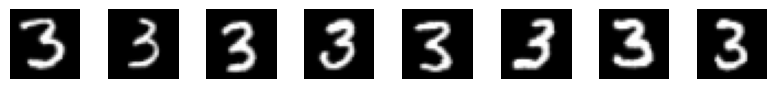

In [8]:
fig, axs = plt.subplots(1, num_samples, figsize=(num_samples, 1))
for i, ax in enumerate(axs):
    ax.imshow(samples[i, 0], cmap="gray", vmin=0, vmax=255)
    ax.axis("off")
plt.tight_layout()
plt.show()